# Wine Quality Study

In this project I am analyzing a data set on wine quality taken from the [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html). The data consists of a chemical analysis of many types of wine and each is given a quality score. You can read more about the data [here](http://archive.ics.uci.edu/ml/index.html).

In [1]:
import numpy as np

import pandas as pd
from pandas.tools.plotting import scatter_matrix

import matplotlib.pyplot as plt
import ggplot

import seaborn as sb
sb.set()

%matplotlib inline

## Load the data

In [59]:
red_wine = pd.read_csv('winequality-red.csv',sep=';')
white_wine = pd.read_csv('winequality-white.csv',sep=';')

I will focus on the red wines for this study. Let's see how the red wines range in quality score.

In [60]:
print "The range is wine quality is {0}".format(np.sort(red_wine['quality'].unique()))

The range is wine quality is [3 4 5 6 7 8]


I know bin the data into three bins based on their quality, 'Bad', 'Average', and 'Good'.

In [61]:
bins = [3, 5, 6, 8]
red_wine['category'] = pd.cut(red_wine.quality, bins, labels=['Bad', 'Average', 'Good'])

### Scatter plot matrix
To better understand the data, I will use seaborn to make a scatter plot matrix. This is a plot comparing all values in the data set by plotting one value versus the other. It provides a good way to see how the different features are related to eachother.

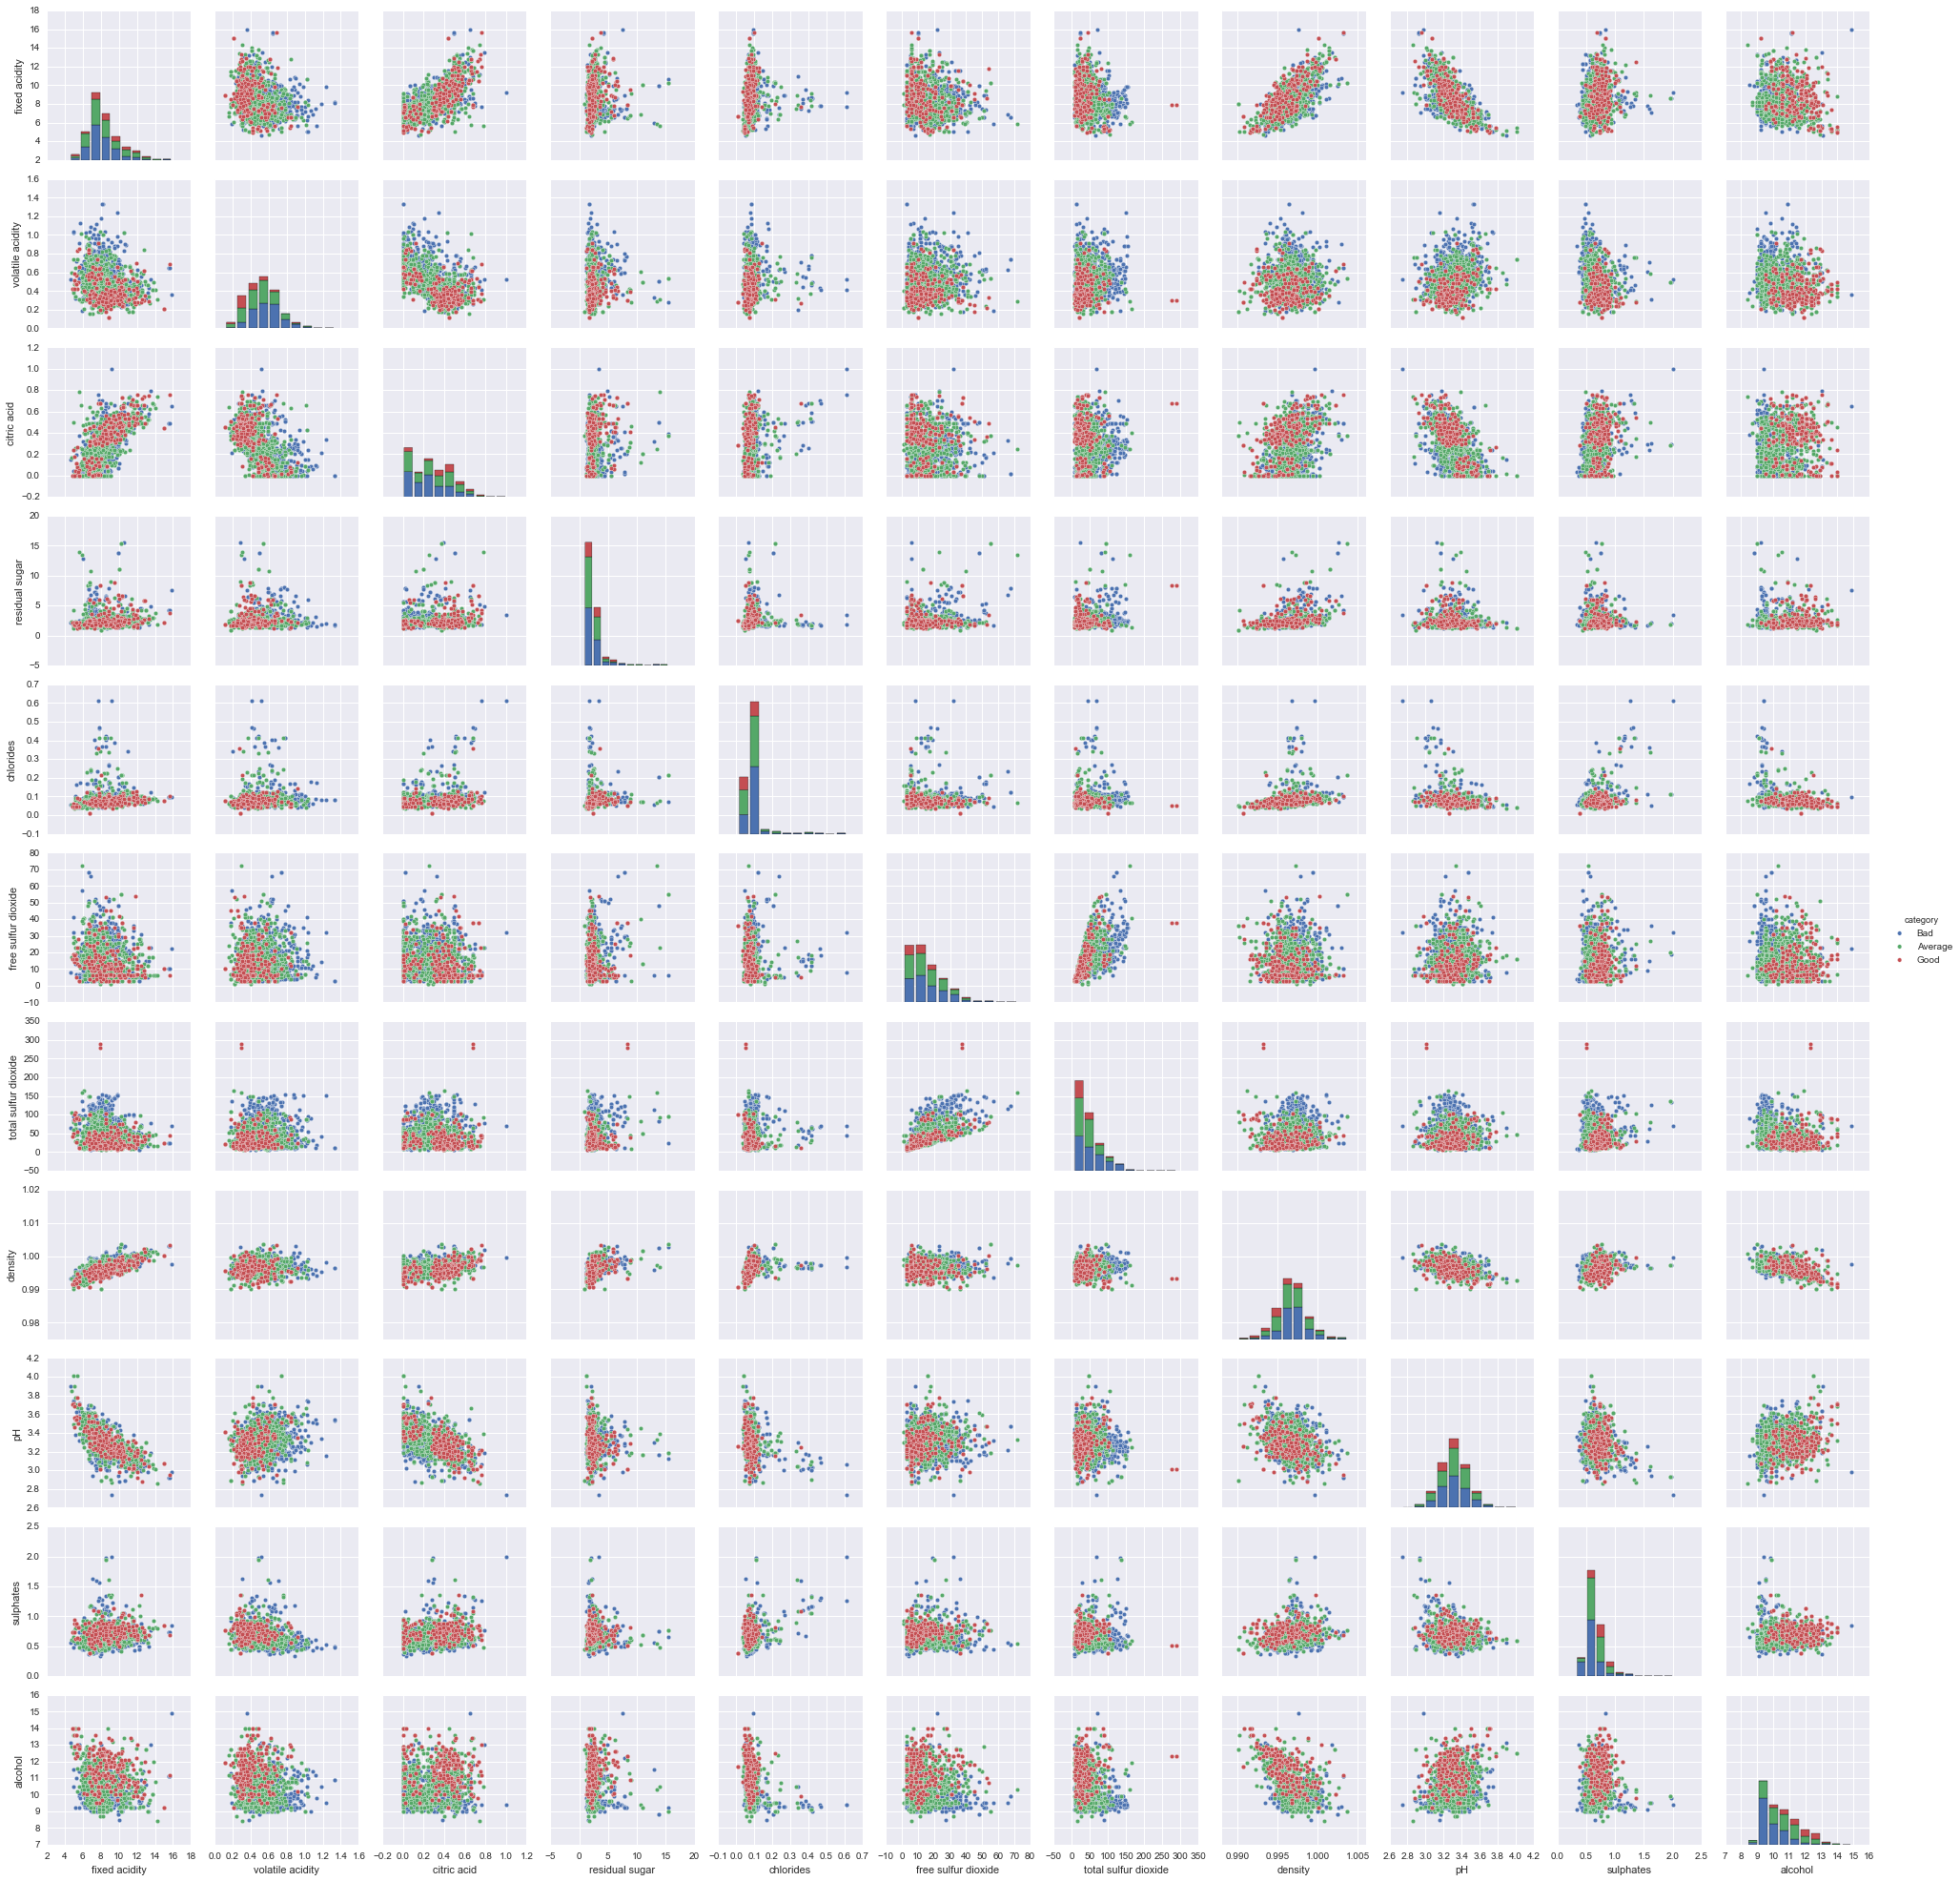

In [62]:
sb.pairplot(red_wine.drop(['quality'],1),hue='category')

In [63]:
red_wine.drop('quality',1).groupby('category').agg(['mean','std']).T

category                         Bad    Average       Good
fixed acidity        mean   8.139237   8.347179   8.847005
                     std    1.570668   1.797849   1.999977
volatile acidity     mean   0.585484   0.497484   0.405530
                     std    0.171900   0.160962   0.144963
citric acid          mean   0.238665   0.273824   0.376498
                     std    0.182344   0.195108   0.194438
residual sugar       mean   2.540804   2.477194   2.708756
                     std    1.394359   1.441576   1.363026
chlorides            mean   0.092587   0.084956   0.075912
                     std    0.055570   0.039563   0.028480
free sulfur dioxide  mean  16.643052  15.711599  13.981567
                     std   10.891157   9.940911  10.234615
total sulfur dioxide mean  55.050409  40.869906  34.889401
                     std   36.756984  25.038250  32.572238
density              mean   0.997063   0.996615   0.996030
                     std    0.001593   0.002000   0.002201
pH                   mean   3.310477   3.318072   3.288802
                     std    0.154189   0.153995   0.154478
sulphates            mean   0.619196   0.675329   0.743456
                     std    0.176784   0.158650   0.134038
alcohol              mean   9.926090  10.629519  11.518049
                     std    0.757750   1.049639   0.998153

Notice that there is quite a bit of overlap between the average values and the bad values. I will throw out the average values and only perform a classification between the 'Good' wine and the 'Bad' wine.

In [64]:
red_wine = red_wine[red_wine['category'].isin(['Bad','Good'])]

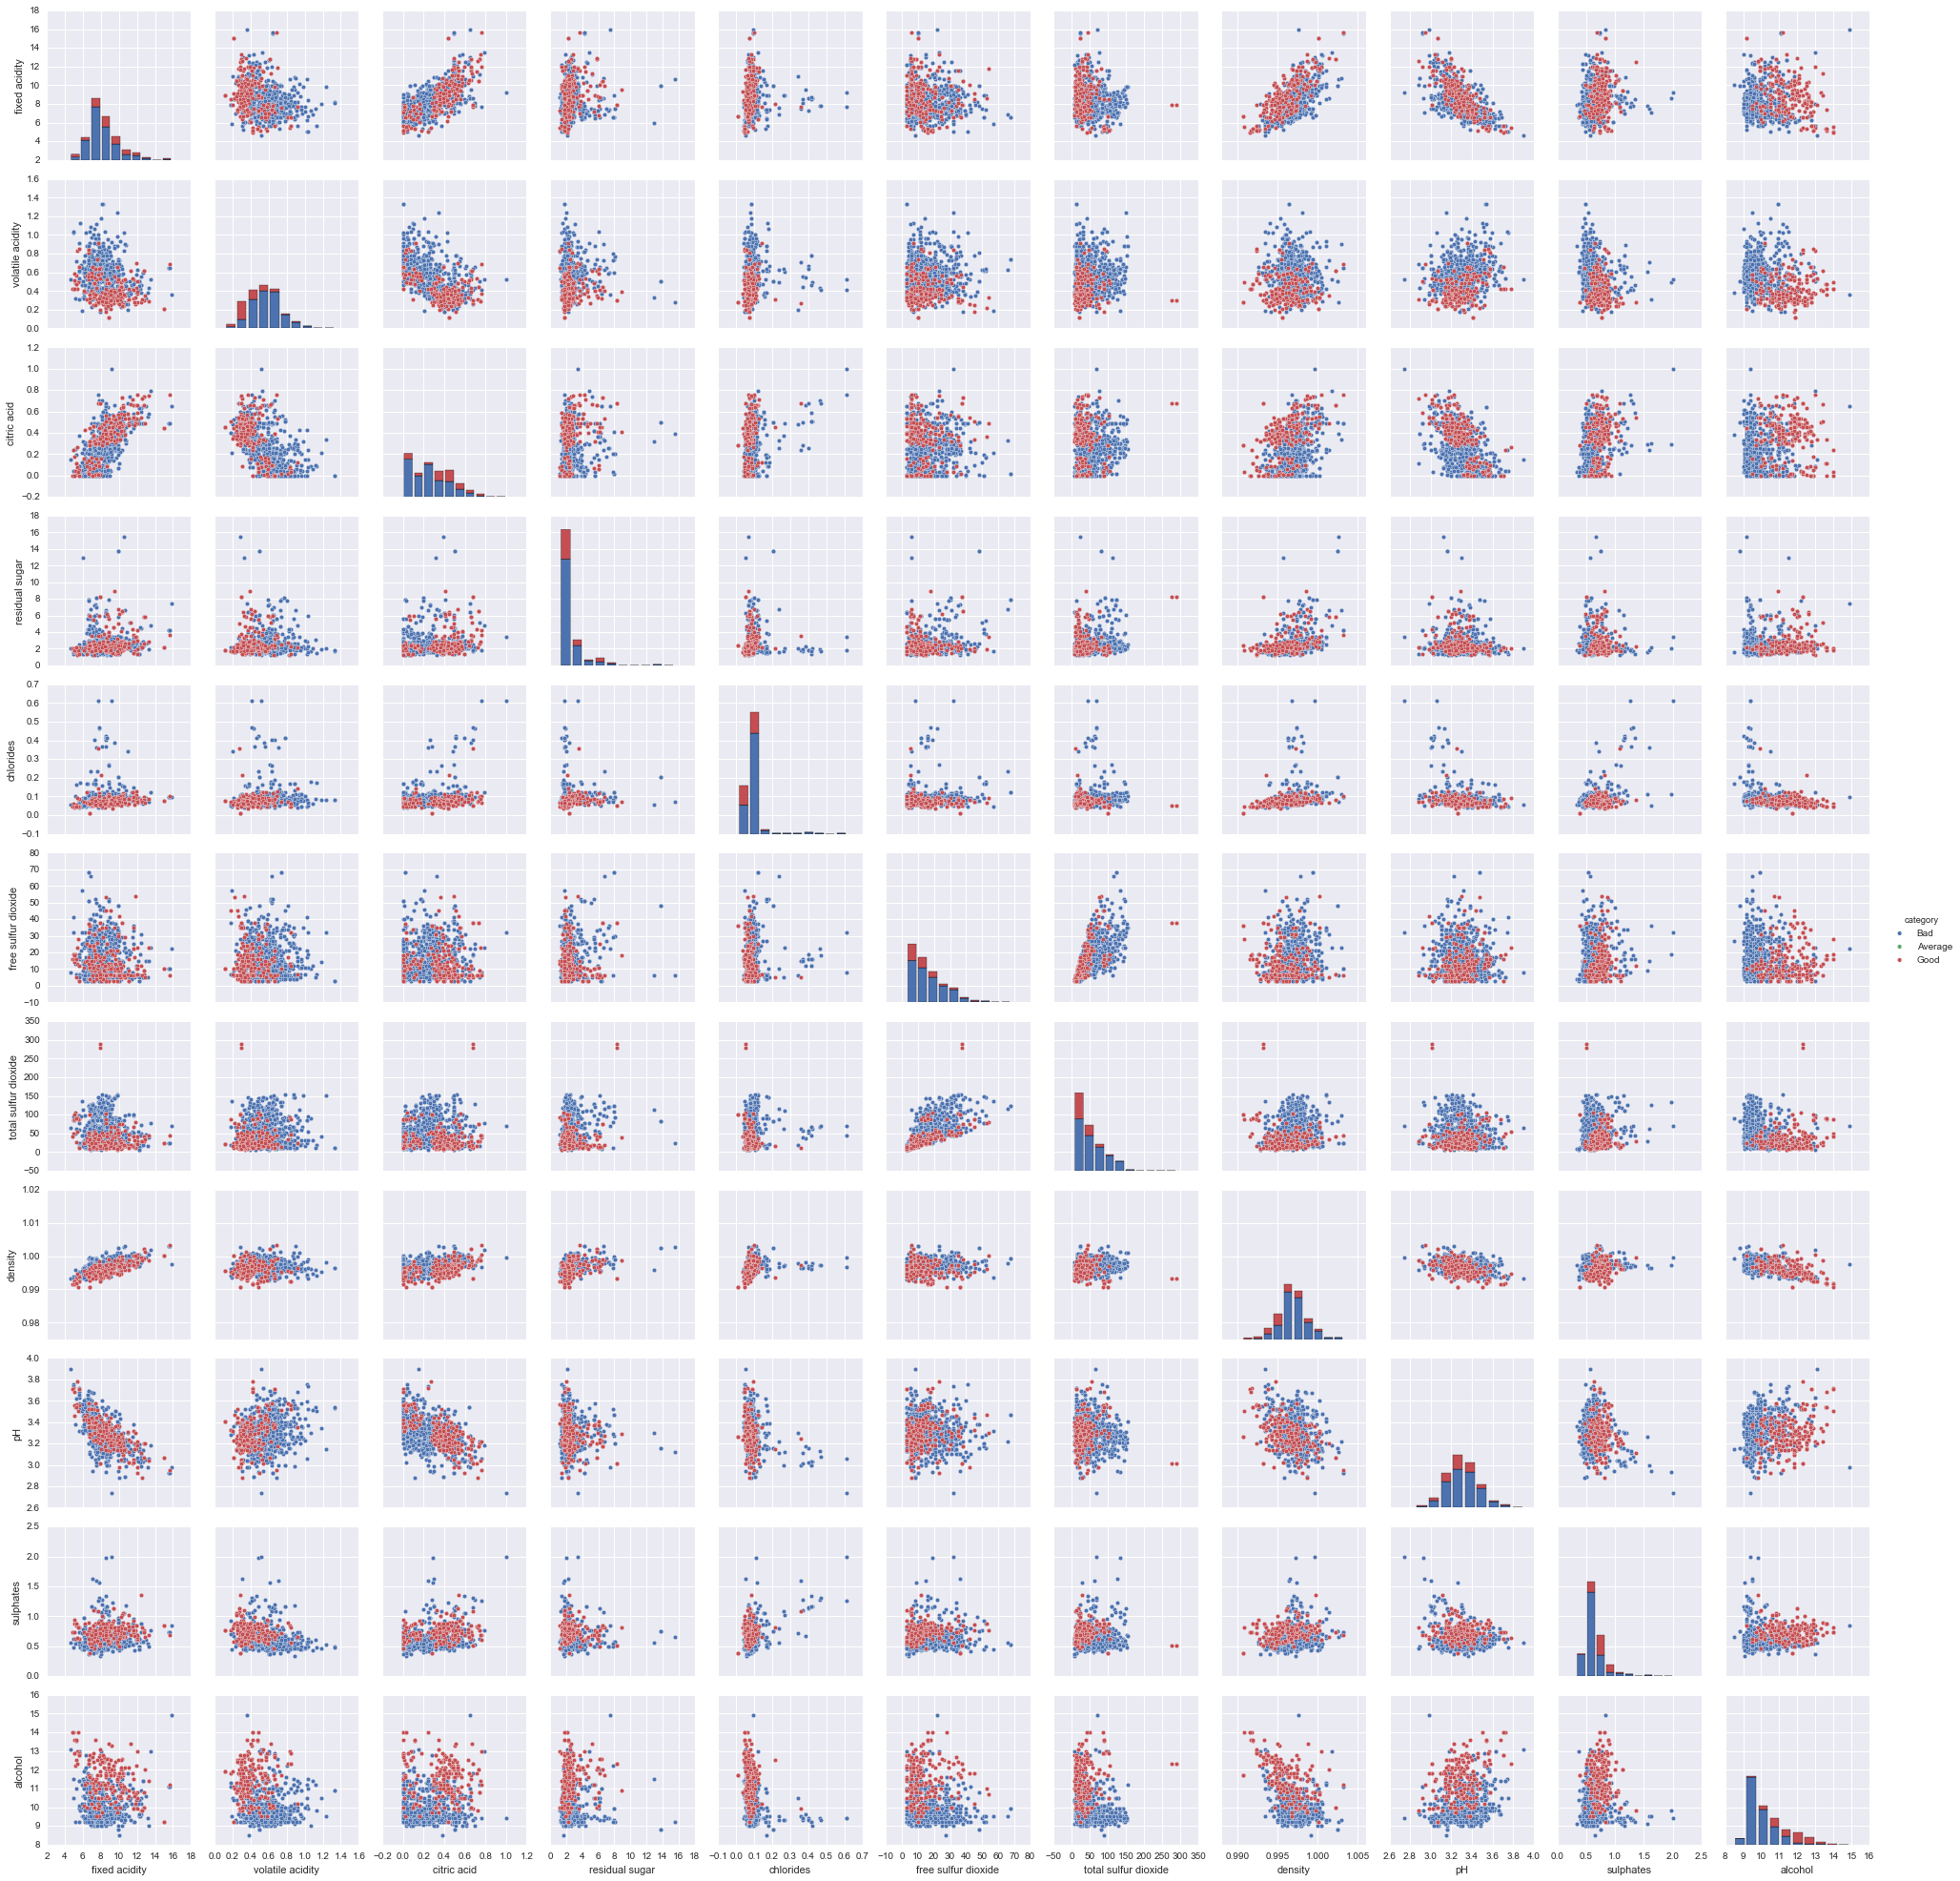

In [65]:
sb.pairplot(red_wine.drop(['quality'],1),hue='category')

In [66]:
red_wine.drop('quality',1).groupby('category').agg(['mean','std']).T

category                         Bad  Average       Good
fixed acidity        mean   8.139237      NaN   8.847005
                     std    1.570668      NaN   1.999977
volatile acidity     mean   0.585484      NaN   0.405530
                     std    0.171900      NaN   0.144963
citric acid          mean   0.238665      NaN   0.376498
                     std    0.182344      NaN   0.194438
residual sugar       mean   2.540804      NaN   2.708756
                     std    1.394359      NaN   1.363026
chlorides            mean   0.092587      NaN   0.075912
                     std    0.055570      NaN   0.028480
free sulfur dioxide  mean  16.643052      NaN  13.981567
                     std   10.891157      NaN  10.234615
total sulfur dioxide mean  55.050409      NaN  34.889401
                     std   36.756984      NaN  32.572238
density              mean   0.997063      NaN   0.996030
                     std    0.001593      NaN   0.002201
pH                   mean   3.310477      NaN   3.288802
                     std    0.154189      NaN   0.154478
sulphates            mean   0.619196      NaN   0.743456
                     std    0.176784      NaN   0.134038
alcohol              mean   9.926090      NaN  11.518049
                     std    0.757750      NaN   0.998153

It looks like volatile acidity is a good indicator of wine quality. I will use this to classify whether the wine is a 'Good' wine or a 'Bad' wine.

## Using skflow

In [47]:
import sklearn
from sklearn import metrics, preprocessing
from sklearn.cross_validation import train_test_split

import skflow

Before using TensorFlow, I will use skflow to make the model.

### Separate data into labels and features
Here I separate the data into 'labels' (y values) and 'feature' (X values) and divide them into training and test sets using train_test_split() from scikit-learn.

In [48]:
y_red_wine = red_wine[['category']].get_values()

In [49]:
X_red_wine = red_wine['volatile acidity'].get_values()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_red_wine, y_red_wine, test_size=0.2, random_state=42)

The y values are string categories ('Good' and 'Bad') and so need to be converted to integers so that skflow will understand the categories. This is done using fit_transform() from the CategoricalProcessor class in skflow.

In [67]:
cat_processor = skflow.preprocessing.CategoricalProcessor()
y_train = np.array(list(cat_processor.fit_transform(y_train)))
y_test = np.array(list(cat_processor.transform(y_test)))

In [52]:
n_classes = len(cat_processor.vocabularies_[0])

In [68]:
print("There are {0} different classes.").format(n_classes)

There are 3 different classes.


In [54]:
# Define the model
def categorical_model(X, y):
    return skflow.models.logistic_regression(X, y)

In [55]:
# Train the model
classifier = skflow.TensorFlowEstimator(model_fn=categorical_model,
    n_classes=3, learning_rate=1.0)

In [56]:
classifier.fit(X_train, y_train)

Step #1, avg. loss: 1.05360
Step #21, avg. loss: 0.58278
Step #41, epoch #1, avg. loss: 0.49059
Step #61, epoch #2, avg. loss: 0.52084
Step #81, epoch #3, avg. loss: 0.47123
Step #101, epoch #4, avg. loss: 0.46779
Step #121, epoch #5, avg. loss: 0.45029
Step #141, epoch #5, avg. loss: 0.45510
Step #161, epoch #6, avg. loss: 0.43534
Step #181, epoch #7, avg. loss: 0.46607


TensorFlowEstimator(batch_size=32, class_weight=None, continue_training=False,
          early_stopping_rounds=None, keep_checkpoint_every_n_hours=10000,
          learning_rate=1.0, max_to_keep=5,
          model_fn=<function categorical_model at 0x12f11f1b8>,
          n_classes=3, num_cores=4, optimizer='SGD', steps=200,
          tf_master='', tf_random_seed=42, verbose=1)

In [57]:
print("Accuracy: {0}".format(metrics.accuracy_score(classifier.predict(X_test), y_test)))

Accuracy: 0.769633507853


Not bad for a start! Now the model needs to be revised.

### Next steps:
* Convert code into TensorFlow and run the model.